The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

==================== SCENARIO: CASE STUDY 1: BALANCED OUTLOOK ====================

--- Running with Configuration ---
  Number of simulations: 10,000
  Property Value Initial: £550,000
  Holding Period:         15 years
  Fixed Term Length:      5 years
  Initial Mortgage Rate:  4.35%
  Deposit Percentage:     25%
  Initial Service Charge: £6,500 p.a.
  Remortgage Fee:         £1,000

Distribution Assumptions (Mean / Std Dev):
  Property Apprec.:       3.0% / 5.0%
  Alt. Investment Ret.:    5.0% / 8.0%
  Service Chg Infl.:      3.5% / 2.5%
  Remortgage Rate:       4.8% / 1.5%

--- Running 10,000 Simulations ---
Duration: 2.09 seconds

--- Processing Results ---

--- Analysis for: Case Study 1: Balanced Outlook ---

--- Monte Carlo Results Summary ---

--- Cash Scenario ---
  Net Gain:
mean      £83,613
std      £159,955
min     £-402,675
5%      £-152,165
50%       £67,447
95%      £370,274
max   

/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '£83,613' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_ng['mean'] = f"£{stats_ng['mean']:,.0f}"
/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.72%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_roi['mean'] = f"{stats_roi['mean']:.2f}%"
/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '£888,578' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_ng['mean'] = f"£{stats_ng['mean']:,.0f}"
/Users/

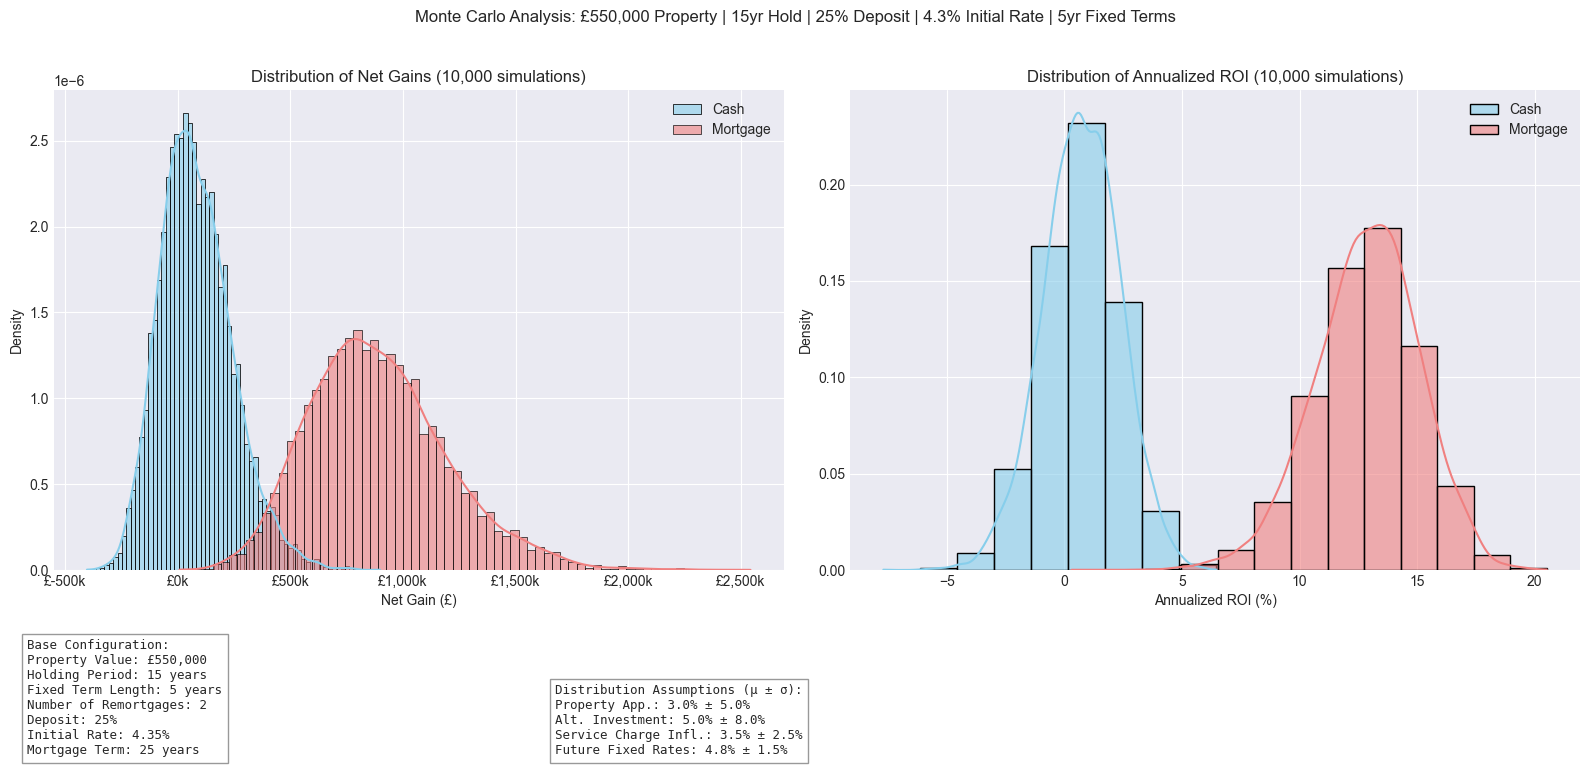

==================== END SCENARIO: CASE STUDY 1: BALANCED OUTLOOK ====================


==================== SCENARIO: CASE STUDY 2: HIGHER INFLATION/RATES WORLD ====================

--- Running with Configuration ---
  Number of simulations: 10,000
  Property Value Initial: £550,000
  Holding Period:         15 years
  Fixed Term Length:      5 years
  Initial Mortgage Rate:  4.35%
  Deposit Percentage:     25%
  Initial Service Charge: £6,500 p.a.
  Remortgage Fee:         £1,000

Distribution Assumptions (Mean / Std Dev):
  Property Apprec.:       2.0% / 5.0%
  Alt. Investment Ret.:    4.5% / 8.0%
  Service Chg Infl.:      4.5% / 3.0%
  Remortgage Rate:       6.0% / 2.0%

--- Running 10,000 Simulations ---
Duration: 2.12 seconds

--- Processing Results ---

--- Analysis for: Case Study 2: Higher Inflation/Rates World ---

--- Monte Carlo Results Summary ---

--- Cash Scenario ---
  Net Gain:
mean     £-47,663
std      £138,423
min     £-427,035
5%      £-252,386
50%      £-59,268


/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '£-47,663' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_ng['mean'] = f"£{stats_ng['mean']:,.0f}"
/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.79%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_roi['mean'] = f"{stats_roi['mean']:.2f}%"
/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '£651,835' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_ng['mean'] = f"£{stats_ng['mean']:,.0f}"
/User

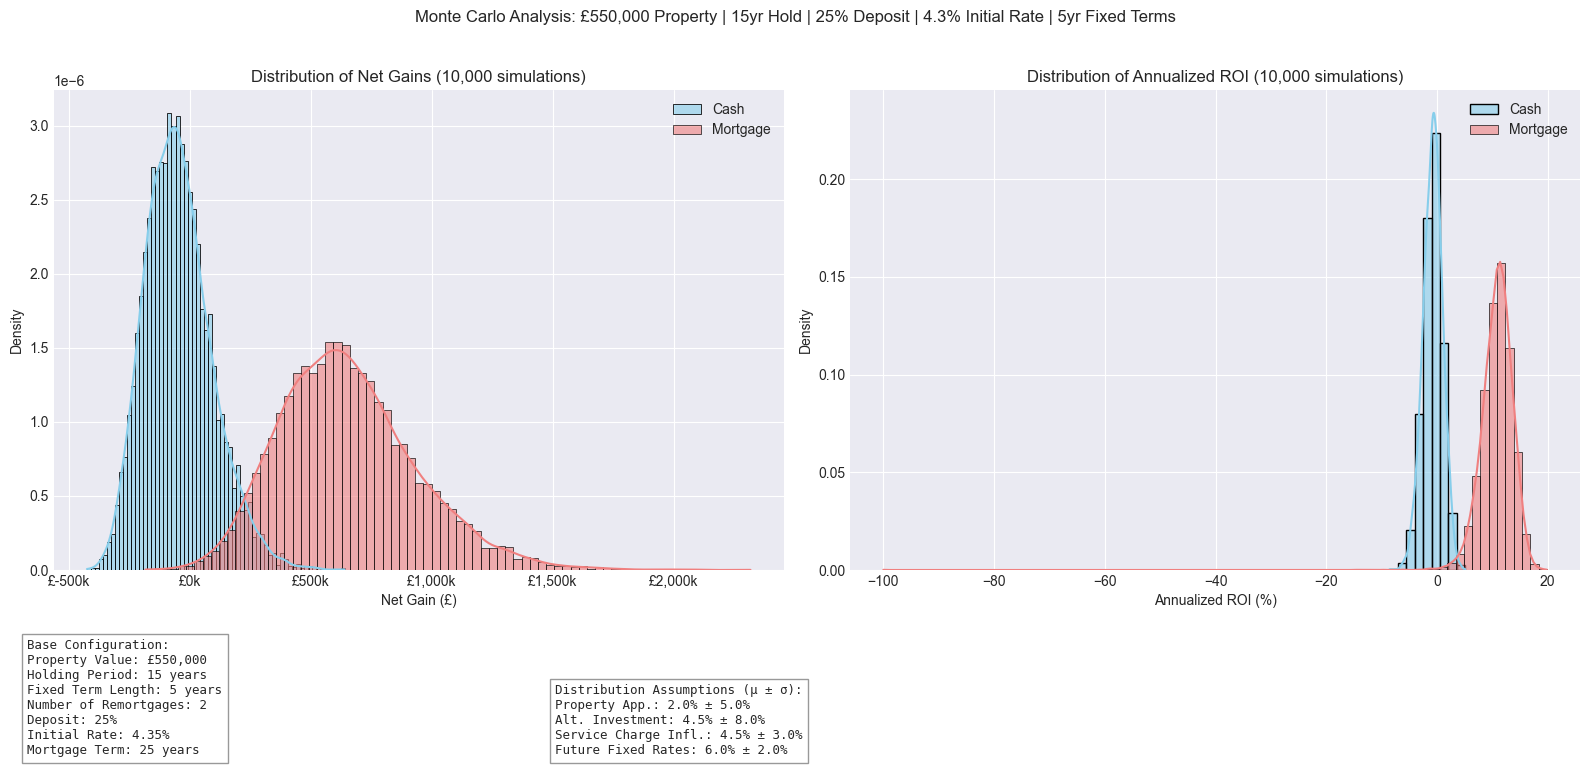

==================== END SCENARIO: CASE STUDY 2: HIGHER INFLATION/RATES WORLD ====================


==================== SCENARIO: CASE STUDY 3: STAGNANT PROPERTY / LOWER RETURNS ====================

--- Running with Configuration ---
  Number of simulations: 10,000
  Property Value Initial: £550,000
  Holding Period:         15 years
  Fixed Term Length:      5 years
  Initial Mortgage Rate:  4.35%
  Deposit Percentage:     25%
  Initial Service Charge: £6,500 p.a.
  Remortgage Fee:         £1,000

Distribution Assumptions (Mean / Std Dev):
  Property Apprec.:       1.0% / 4.0%
  Alt. Investment Ret.:    3.0% / 5.0%
  Service Chg Infl.:      3.0% / 2.5%
  Remortgage Rate:       4.5% / 1.5%

--- Running 10,000 Simulations ---
Duration: 2.23 seconds

--- Processing Results ---

--- Analysis for: Case Study 3: Stagnant Property / Lower Returns ---

--- Monte Carlo Results Summary ---

--- Cash Scenario ---
  Net Gain:
mean    £-125,200
std       £96,930
min     £-407,414
5%      £-271,

/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '£-125,200' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_ng['mean'] = f"£{stats_ng['mean']:,.0f}"
/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.76%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_roi['mean'] = f"{stats_roi['mean']:.2f}%"
/Users/Joseph/repos/mortgage_stuff/mc_analysis.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '£478,020' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  stats_ng['mean'] = f"£{stats_ng['mean']:,.0f}"
/Use

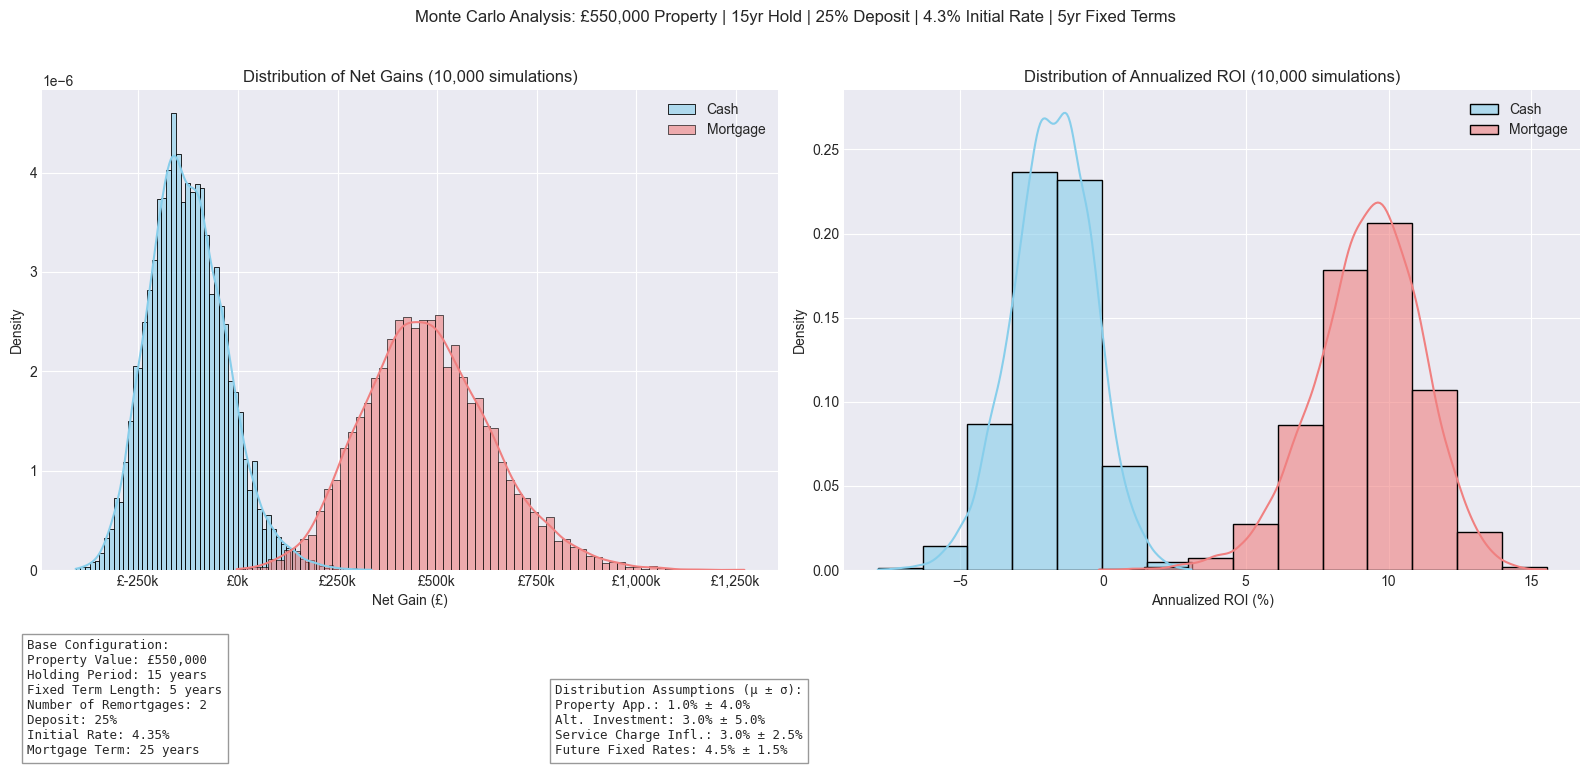

==================== END SCENARIO: CASE STUDY 3: STAGNANT PROPERTY / LOWER RETURNS ====================



==================== CASE STUDY COMPARISON ACROSS ALL 3 SCENARIOS ====================


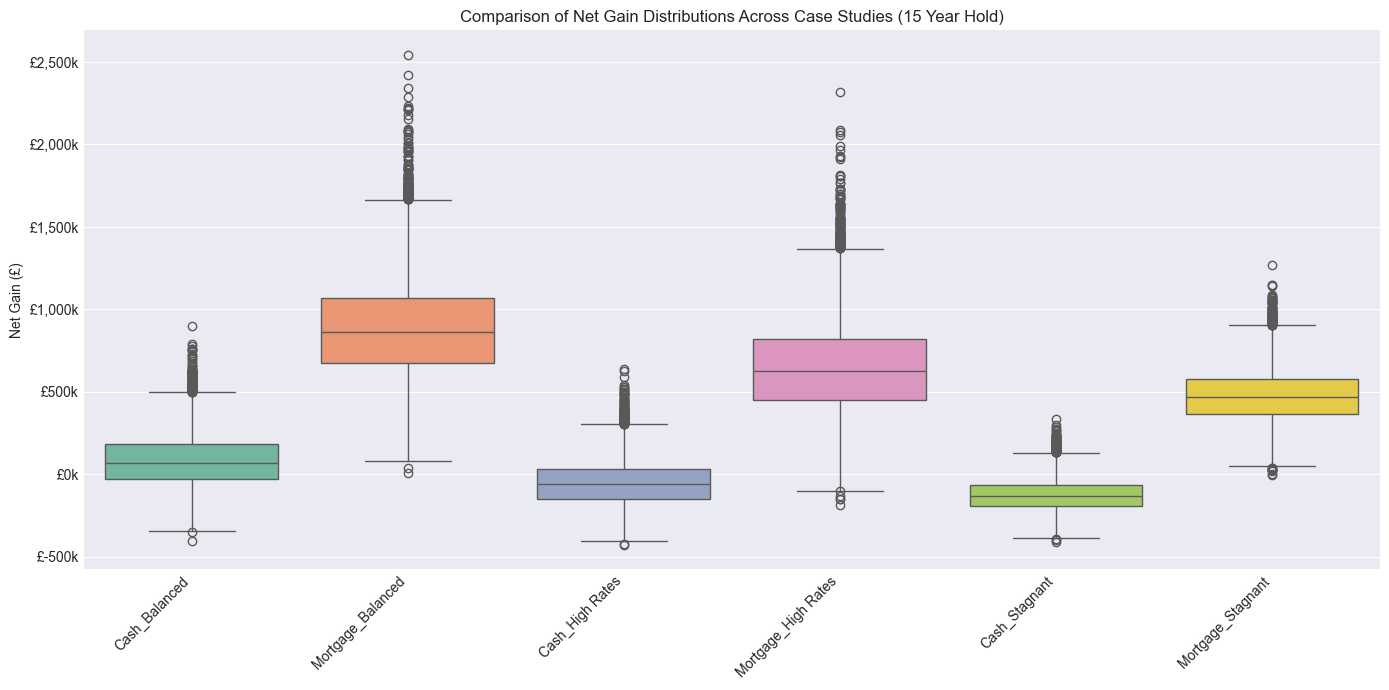

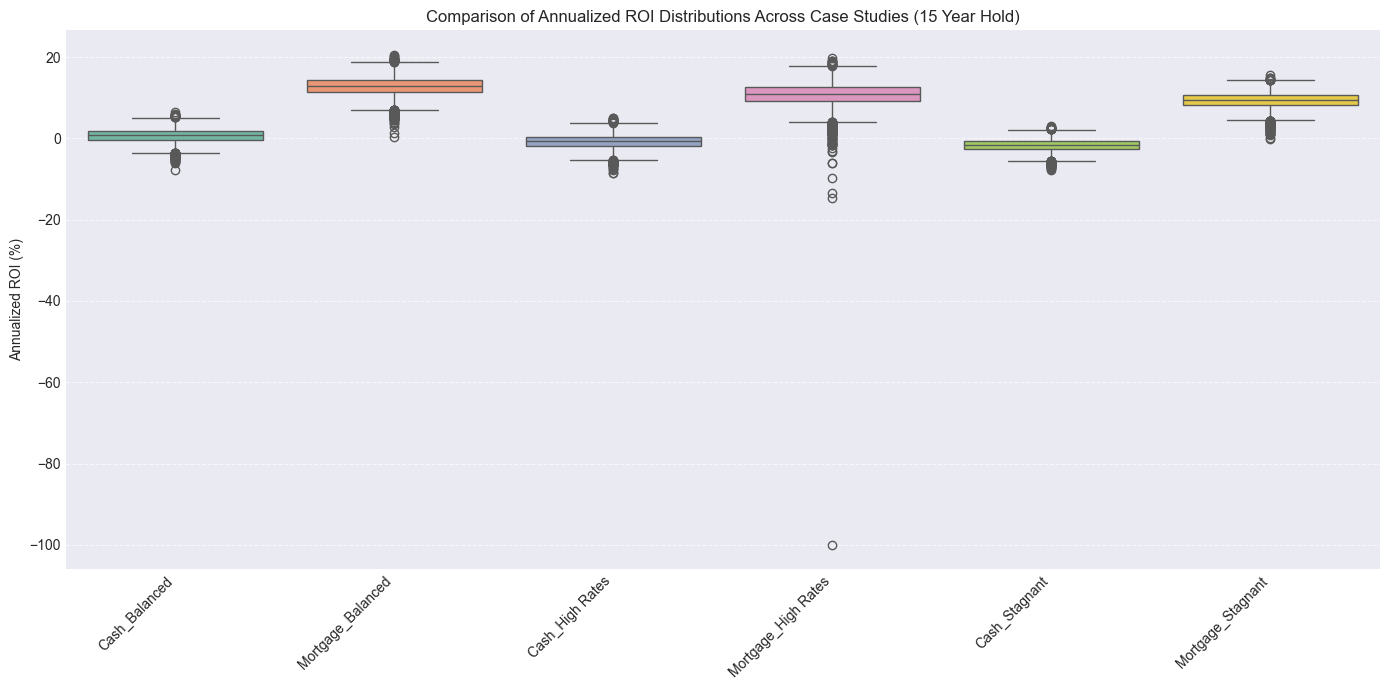


--- Net Gain Comparison Summary Statistics (£k) ---
       Cash_Balanced  Mortgage_Balanced  Cash_High Rates  Mortgage_High Rates  Cash_Stagnant  Mortgage_Stagnant
count            10k                10k              10k                  10k            10k                10k
mean             84k               889k             -48k                 652k          -125k               478k
std             160k               305k             138k                 284k            97k               162k
min            -403k                 8k            -427k                -185k          -407k                -3k
5%             -152k               442k            -252k                 237k          -272k               229k
25%             -30k               673k            -146k                 451k          -194k               366k
50%              67k               862k             -59k                 626k          -132k               469k
75%             182k             1,070k            

In [6]:
# --- Imports and Setup ---
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import copy

from mortgage_mc import get_base_config, run_monte_carlo_simulation
from mc_analysis import (
    process_mc_results,
    display_summary_stats,
    display_probability_analysis,
    plot_mc_distributions
)

# --- Helper Function to Run, Analyze, and Plot a Scenario ---
def run_and_analyze_scenario(scenario_name: str, config_overrides: dict, dist_assumptions: dict, num_simulations: int = 10000):
    """
    Runs MC simulation for a scenario, displays analysis, and plots distributions.

    Args:
        scenario_name (str): Name for the scenario (used in prints/titles).
        config_overrides (dict): Dictionary of base_config values to override.
        dist_assumptions (dict): Dictionary of distribution parameters (means/std devs).
        num_simulations (int): Number of Monte Carlo iterations.

    Returns:
        pd.DataFrame: Processed DataFrame with Net Gain and ROI results, or None if failed.
    """
    print(f"\n{'='*20} SCENARIO: {scenario_name.upper()} {'='*20}")

    # Create config for this scenario using function from mortgage_mc.py
    scenario_config = get_base_config()
    scenario_config.update(config_overrides) # Apply specific overrides

    # Print key parameters for this scenario run
    print("\n--- Running with Configuration ---")
    print(f"  Number of simulations: {num_simulations:,}")
    print(f"  Property Value Initial: £{scenario_config['property_value_initial']:,.0f}")
    print(f"  Holding Period:         {scenario_config['holding_period_years']} years")
    print(f"  Fixed Term Length:      {scenario_config.get('fixed_term_length_years', 5)} years") # Default to 5 if not in config
    print(f"  Initial Mortgage Rate:  {scenario_config['initial_mortgage_interest_rate_annual']:.2%}")
    print(f"  Deposit Percentage:     {scenario_config['deposit_percentage']:.0%}")
    print(f"  Initial Service Charge: £{scenario_config['service_charge_annual_initial']:,.0f} p.a.")
    print(f"  Remortgage Fee:         £{scenario_config.get('remortgage_fee', 0):,.0f}")

    print("\nDistribution Assumptions (Mean / Std Dev):")
    print(f"  Property Apprec.:       {dist_assumptions['prop_app_mean']:.1%} / {dist_assumptions['prop_app_std_dev']:.1%}")
    print(f"  Alt. Investment Ret.:    {dist_assumptions['alt_inv_mean']:.1%} / {dist_assumptions['alt_inv_std_dev']:.1%}")
    print(f"  Service Chg Infl.:      {dist_assumptions['sc_inf_mean']:.1%} / {dist_assumptions['sc_inf_std_dev']:.1%}")
    print(f"  Remortgage Rate:       {dist_assumptions['remort_rate_mean']:.1%} / {dist_assumptions['remort_rate_std_dev']:.1%}")

    # Run Simulation using function from mortgage_mc.py
    print(f"\n--- Running {num_simulations:,} Simulations ---")
    start_time = time.time()
    cash_results, mortgage_results = run_monte_carlo_simulation(
        base_config=scenario_config, # Pass the scenario-specific config
        num_simulations=num_simulations,
        **dist_assumptions
    )
    end_time = time.time()
    print(f"Duration: {end_time - start_time:.2f} seconds")

    # Process Results using function from mc_analysis.py
    print("\n--- Processing Results ---")
    df_processed = process_mc_results(cash_results, mortgage_results, scenario_config['holding_period_years'])

    # Display Analysis & Plots for THIS scenario using functions from mc_analysis.py
    if not df_processed.empty:
        print(f"\n--- Analysis for: {scenario_name} ---")
        display_summary_stats(df_processed)
        display_probability_analysis(df_processed)
        # Call the plotting function to show distributions for this specific scenario
        plot_mc_distributions(df_processed, num_simulations, scenario_config, dist_assumptions)
    else:
        print("Error: No results processed for this scenario.")
        return None # Return None if processing failed

    print(f"{'='*20} END SCENARIO: {scenario_name.upper()} {'='*20}\n")
    return df_processed # Return DataFrame for later comparison


 # Dictionary to store results DataFrames
scenario_results = {}

# --- Case Study 1: Balanced Outlook ---
config1_overrides = {
    "property_value_initial": 550000.0,
    "holding_period_years": 15,
    "fixed_term_length_years": 5,
    "initial_mortgage_interest_rate_annual": 0.0435 # Assumed 4.35% initial 5yr fix
}
dist1_assumptions = {
    "prop_app_mean": 0.03, "prop_app_std_dev": 0.05,
    "alt_inv_mean": 0.05, "alt_inv_std_dev": 0.08,
    "sc_inf_mean": 0.035, "sc_inf_std_dev": 0.025,
    "remort_rate_mean": 0.0475, "remort_rate_std_dev": 0.015
}
scenario_results["Balanced"] = run_and_analyze_scenario(
    "Case Study 1: Balanced Outlook",
    config1_overrides,
    dist1_assumptions
)

# --- Case Study 2: Higher Inflation/Rates World ---
config2_overrides = {
    "property_value_initial": 550000.0,
    "holding_period_years": 15,
    "fixed_term_length_years": 5, # Still aiming for 5yr fixes
    "initial_mortgage_interest_rate_annual": 0.0435
}
dist2_assumptions = {
    "prop_app_mean": 0.02, "prop_app_std_dev": 0.05,
    "alt_inv_mean": 0.045, "alt_inv_std_dev": 0.08,
    "sc_inf_mean": 0.045, "sc_inf_std_dev": 0.03,
    "remort_rate_mean": 0.06, "remort_rate_std_dev": 0.02
}
scenario_results["High Rates"] = run_and_analyze_scenario(
    "Case Study 2: Higher Inflation/Rates World",
    config2_overrides,
    dist2_assumptions
)

# --- Case Study 3: Stagnant Property / Lower Returns ---
config3_overrides = {
    "property_value_initial": 550000.0,
    "holding_period_years": 15,
    "fixed_term_length_years": 5,
    "initial_mortgage_interest_rate_annual": 0.0435
}
dist3_assumptions = {
    "prop_app_mean": 0.01, "prop_app_std_dev": 0.04,
    "alt_inv_mean": 0.03, "alt_inv_std_dev": 0.05,
    "sc_inf_mean": 0.03, "sc_inf_std_dev": 0.025,
    "remort_rate_mean": 0.045, "remort_rate_std_dev": 0.015
}
scenario_results["Stagnant"] = run_and_analyze_scenario(
    "Case Study 3: Stagnant Property / Lower Returns",
    config3_overrides,
    dist3_assumptions
)


# --- Compare Case Studies (Box Plots & Summary Table) ---

# Check if all scenarios ran successfully and produced results DataFrame
valid_scenario_results = {
    name: df for name, df in scenario_results.items()
    if df is not None and isinstance(df, pd.DataFrame) and not df.empty
}
scenario_names = ["Balanced", "High Rates", "Stagnant"] # Define the expected order

assert len(valid_scenario_results) == len(scenario_names) # Check if all expected scenarios completed
print("\n\n" + "="*20 + " CASE STUDY COMPARISON ACROSS ALL 3 SCENARIOS " + "="*20)

# --- Corrected DataFrame Construction ---
net_gain_data = {}
roi_data = {}

for name in scenario_names: # Use the defined order
    df = valid_scenario_results[name]
    # Add data for Cash and Mortgage for this scenario
    net_gain_data[f'Cash_{name}'] = df['Cash Net Gain']
    net_gain_data[f'Mortgage_{name}'] = df['Mortgage Net Gain']
    roi_data[f'Cash_{name}'] = df['Cash ROI (%)']
    roi_data[f'Mortgage_{name}'] = df['Mortgage ROI (%)']

# Create the final DataFrames from the complete dictionaries
comparison_net_gain = pd.DataFrame(net_gain_data)
comparison_roi = pd.DataFrame(roi_data)
# --- End Correction ---

# Define the desired column order
col_order = [f"{ctype}_{sname}" for sname in scenario_names for ctype in ["Cash", "Mortgage"]]

# Reorder the columns, ensuring only valid columns are included
valid_cols_ng = [col for col in col_order if col in comparison_net_gain.columns]
valid_cols_roi = [col for col in col_order if col in comparison_roi.columns]
comparison_net_gain = comparison_net_gain[valid_cols_ng]
comparison_roi = comparison_roi[valid_cols_roi]

# --- Plotting Comparisons ---
plt.style.use('seaborn-v0_8-darkgrid')
from matplotlib.ticker import FuncFormatter # Ensure formatter is imported here too

# Net Gain Comparison Boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(data=comparison_net_gain, palette="Set2")
plt.title('Comparison of Net Gain Distributions Across Case Studies (15 Year Hold)')
plt.ylabel('Net Gain (£)')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'£{x/1000:,.0f}k')) # Format as £k
plt.tight_layout()
plt.show()

# ROI Comparison Boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(data=comparison_roi, palette="Set2")
plt.title('Comparison of Annualized ROI Distributions Across Case Studies (15 Year Hold)')
plt.ylabel('Annualized ROI (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Display Comparison Summary Statistics Table ---
print("\n--- Net Gain Comparison Summary Statistics (£k) ---")
summary_ng = comparison_net_gain.describe(percentiles=[.05, .25, .5, .75, .95]) / 1000
print(summary_ng.to_string(float_format='{:,.0f}k'.format))
print("Could not generate Net Gain summary.")

print("\n--- Annualized ROI Comparison Summary Statistics (%) ---")
summary_roi = comparison_roi.describe(percentiles=[.05, .25, .5, .75, .95])